Found annotations at '/home/dan/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation-1000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Connected to FiftyOne on port 5151 at localhost.
If you are not connecting to a remote session, you may need to start a new session and specify a port



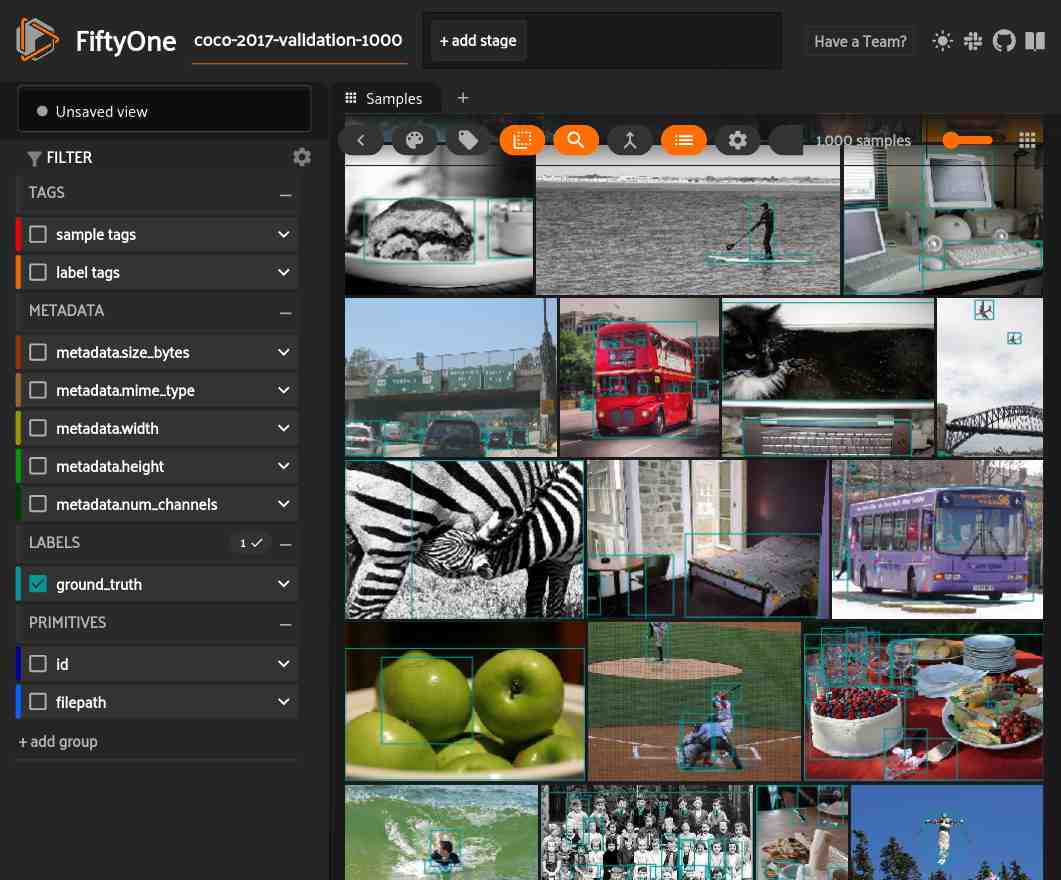

In [2]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("coco-2017", split="validation", max_samples=1000)

session = fo.launch_app(dataset)

In [5]:
model = foz.load_zoo_model("detection-transformer-torch")
dataset.apply_model(model, label_field="zoo_predictions")

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/26.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

 100% |███████████████| 1000/1000 [4.3m elapsed, 0s remaining, 3.2 samples/s]      


In [4]:
from ultralytics import YOLO

# YOLOv8
model = YOLO("yolov8s.pt")

# model = YOLO("yolov8m.pt")
# model = YOLO("yolov8l.pt")
# model = YOLO("yolov8x.pt")

# YOLOv5
# model = YOLO("yolov5s.pt")
# model = YOLO("yolov5m.pt")
# model = YOLO("yolov5l.pt")
# model = YOLO("yolov5x.pt")

# YOLOv9
# model = YOLO("yolov9c.pt")
# model = YOLO("yolov9e.pt")
dataset.apply_model(model, label_field="YOLOv8")

100%|██████████| 21.5M/21.5M [00:01<00:00, 18.9MB/s]


 100% |███████████████| 1000/1000 [13.6s elapsed, 0s remaining, 75.4 samples/s]      


In [61]:
def convert_xyxy_boxes(sample, boxes):
    new_boxes = []
    
    for box in boxes:
        nx = box[0] / sample.metadata.width
        ny = box[1] / sample.metadata.height
        nw = (box[2] - box[0]) / sample.metadata.width
        nh = (box[3] - box[1]) / sample.metadata.height
        new_box = [nx, ny, nw, nh]
        new_boxes.append(new_box)
        
    return new_boxes

In [79]:
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)


for sample in dataset:
    
    image = read_image(sample.filepath)

    preprocess = weights.transforms()

    # Step 3: Apply inference preprocessing transforms
    batch = [preprocess(image)]

    # For inference
    model.eval()
    prediction = model(batch)[0]
    labels = [weights.meta["categories"][i] for i in prediction["labels"]]
    fo_boxes = convert_xyxy_boxes(sample, prediction["boxes"].tolist())
    detections = []
    
    for cls, box, conf in zip(classes, fo_boxes, confs):
        
        det = fo.Detection(label=coco_classes[int(cls)], bounding_box=box, confidence=conf)
        detections.append(det)
        
    sample["torchvision"] = fo.Detections(detections=detections)
    sample.save()


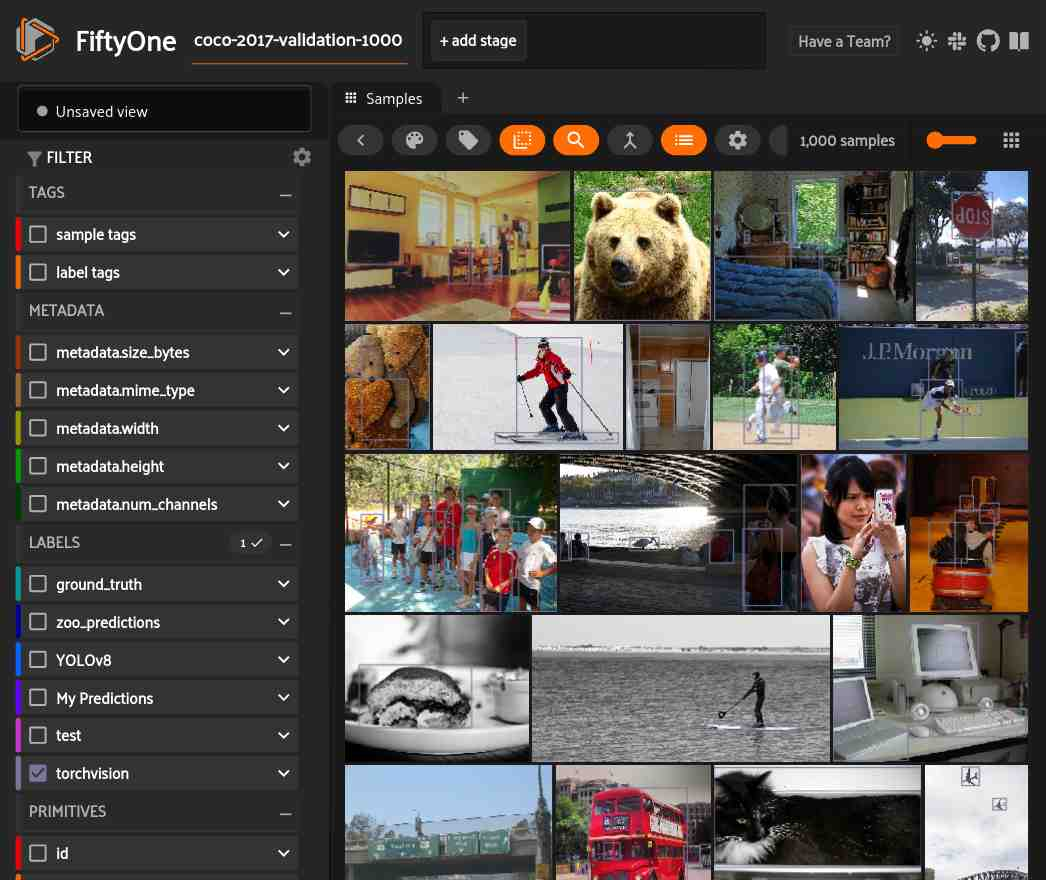

In [81]:
session.show()